# Seq2Seq S&P 500 Price Prediction LSTM with Wavelet Transforms and an Attention Mechanism

In [1]:
import yfinance as yf
import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pywt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from keras.optimizers import Adam
from keras import metrics
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)
from keras.utils.vis_utils import plot_model
from keras import backend as K
import matplotlib.pyplot as plt

In [2]:
ticker = yf.Ticker('spy')
today = datetime.datetime.now().date().strftime("%Y-%m-%d")
history = ticker.history(start="2000-01-01", end=today)
opens = history.Open
highs = history.High
lows = history.Low
closes = history.Close
volume = history.Volume

data = pd.concat([opens, highs, lows, closes, volume], axis=1)
data.dropna(inplace=True, axis=0)

print(opens.shape)
print(highs.shape)
print(lows.shape)
print(closes.shape)
print(volume.shape)
print(data.shape)

(5693,)
(5693,)
(5693,)
(5693,)
(5693,)
(5693, 5)


In [3]:
train, test = train_test_split(data, test_size=0.1, random_state=42, shuffle=False)
print(train.shape)
print(test.shape)

(5123, 5)
(570, 5)


In [4]:
def WaveletTransform(data, levels, threshold=0.63, wavelet='coif3'):
    reconstructedData = pd.DataFrame()
    for i in range(data.shape[1]):
        threshold = threshold * np.nanmax(data[:,i])
        coefficients = pywt.wavedec(data[:,i], wavelet, mode='per', level=levels)
        coefficients[1:] = (pywt.threshold(i, value=threshold, mode='soft') for i in coefficients[1:])
        reconstructedColumn = pywt.waverec(coefficients, wavelet, mode='per')
        reconstructedData = pd.concat([reconstructedData, pd.DataFrame(reconstructedColumn)], axis=1)
    return np.array(reconstructedData)

scaler = StandardScaler()
scalerTwo = MinMaxScaler()

trainStandardised = scaler.fit_transform(train)
trainNormalised = scalerTwo.fit_transform(trainStandardised)
trainPreprocessed = WaveletTransform(trainNormalised, 3)

testStandardised = scaler.transform(test)
testNormalised = scalerTwo.transform(testStandardised)
testPreprocessed = WaveletTransform(testNormalised, 3)

In [5]:
X_train, y_train = [], []
X_test, y_test, y_truth = [], [], []

exposureSize = 365
predictionSize = 7

for i in range(exposureSize, trainPreprocessed.shape[0]-predictionSize):
    X_train.append(np.concatenate([trainNormalised[i-exposureSize:i], trainPreprocessed[i-exposureSize:i]], axis=1))
    y_train.append(trainNormalised[i:i+predictionSize, 0])

for i in range(exposureSize, testPreprocessed.shape[0]-predictionSize):
    X_test.append(np.concatenate([testNormalised[i-exposureSize:i], testPreprocessed[i-exposureSize:i]], axis=1))
    y_test.append(testNormalised[i:i+predictionSize, 0])
    y_truth.append(test.iloc[i:i+predictionSize, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)
y_truth = np.array(y_truth)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_truth.shape)

(4752, 365, 10)
(4752, 7)
(198, 365, 10)
(198, 7)
(198, 7)


In [6]:
# REF: https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def coefficient_of_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

2022-08-18 15:49:12.092471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                12200     
                                                                 
 repeat_vector (RepeatVector  (None, 7, 50)            0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 7, 50)             20200     
                                                                 
 time_distributed (TimeDistr  (None, 7, 1)             51        
 ibuted)                                                         
                                                                 
Total params: 32,451
Trainable params: 32,451
Non-trainable params: 0
_________________________________________________________________
None


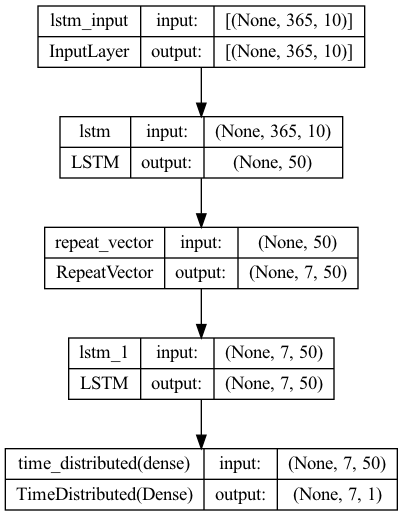

In [7]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(RepeatVector(predictionSize))
model.add(LSTM(50, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
optimiser = Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=optimiser, metrics=[metrics.MeanAbsoluteError(), metrics.MeanSquaredError(), metrics.RootMeanSquaredError(), coefficient_of_determination])
print(model.summary())
plot_model(model, to_file='./Seq2SeqModel.png', show_shapes=True)

In [8]:
numEpochsOne = 16
numEpochsTwo = 12
numEpochsThree = 8

historyOne = model.fit(X_train, y_train, epochs=numEpochsOne, batch_size=32, validation_data=(X_test, y_test), verbose=1)
K.set_value(model.optimizer.learning_rate, 0.001)
historyTwo = model.fit(X_train, y_train, epochs=numEpochsTwo, batch_size=32, validation_data=(X_test, y_test), verbose=1)
K.set_value(model.optimizer.learning_rate, 0.0001)
historyThree = model.fit(X_train, y_train, epochs=numEpochsThree, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/16
149/149 [==============================] - 45s 226ms/step - loss: 0.0042 - mean_absolute_error: 0.0282 - mean_squared_error: 0.0042 - root_mean_squared_error: 0.0651 - coefficient_of_determination: 0.9238 - val_loss: 0.0733 - val_mean_absolute_error: 0.2573 - val_mean_squared_error: 0.0733 - val_root_mean_squared_error: 0.2707 - val_coefficient_of_determination: -92.0421
Epoch 2/16
149/149 [==============================] - 31s 208ms/step - loss: 2.1958e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 2.1958e-04 - root_mean_squared_error: 0.0148 - coefficient_of_determination: 0.9962 - val_loss: 0.0431 - val_mean_absolute_error: 0.1932 - val_mean_squared_error: 0.0431 - val_root_mean_squared_error: 0.2076 - val_coefficient_of_determination: -54.2347
Epoch 3/16
149/149 [==============================] - 34s 225ms/step - loss: 1.5791e-04 - mean_absolute_error: 0.0080 - mean_squared_error: 1.5791e-04 - root_mean_squared_error: 0.0126 - coefficient_of_determination: 0.997

In [9]:
y_hat = model.predict(X_test)

7/7 [==============================] - 1s 21ms/step


In [10]:
# Undo normalisation
y_test = (y_test * scalerTwo.data_range_[0]) + scalerTwo.data_min_[0]
y_hat = (y_hat * scalerTwo.data_range_[0]) + scalerTwo.data_min_[0]
# Undo standardisation
y_test = (y_test * scaler.scale_[0]) + scaler.mean_[0]
y_hat = (y_hat * scaler.scale_[0]) + scaler.mean_[0]

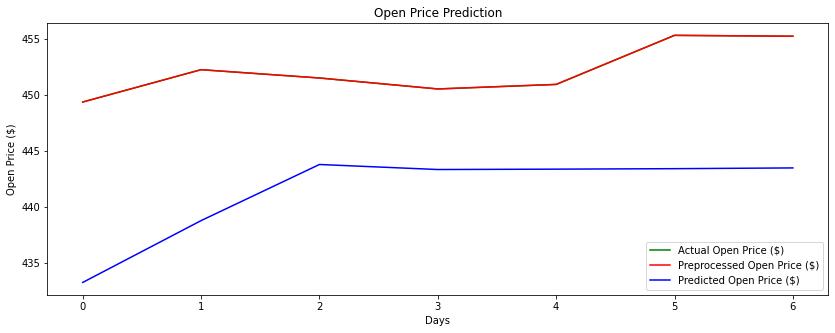

In [11]:
index = 0
plt.figure(figsize=(14, 5))
plt.plot(y_truth[index], color='green', label="Actual Open Price ($)")
plt.plot(y_test[index], color='red', label="Preprocessed Open Price ($)")
plt.plot(y_hat[index], color='blue', label="Predicted Open Price ($)")
plt.title('Open Price Prediction')
plt.xlabel('Days')
plt.ylabel('Open Price ($)')
plt.legend()
plt.show()

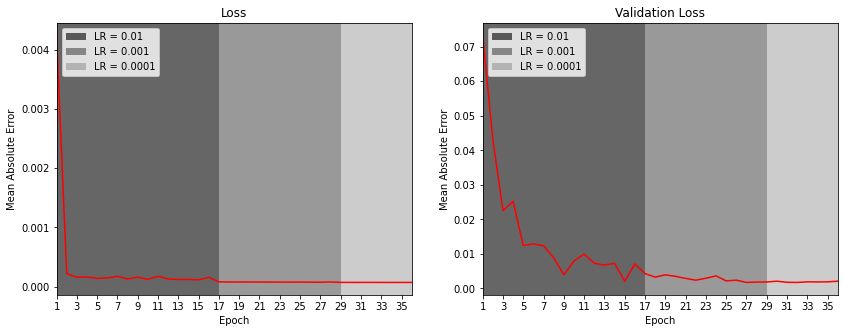

In [12]:
totalLoss = np.concatenate([historyOne.history['loss'], historyTwo.history['loss'], historyThree.history['loss']])
totaValLoss = np.concatenate([historyOne.history['val_loss'], historyTwo.history['val_loss'], historyThree.history['val_loss']])

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(totalLoss, color='red')
plt.axvspan(0, numEpochsOne, facecolor='black', alpha=0.6, label="LR = 0.01")
plt.axvspan(numEpochsOne, numEpochsOne+numEpochsTwo, facecolor='black', alpha=0.4, label="LR = 0.001")
plt.axvspan(numEpochsOne+numEpochsTwo, numEpochsOne+numEpochsTwo+numEpochsThree, facecolor='black', alpha=0.2, label="LR = 0.0001")
plt.xlim(0, numEpochsOne+numEpochsTwo+numEpochsThree-1)
plt.xticks([2*i for i in range((numEpochsOne+numEpochsTwo+numEpochsThree)//2)], [(2*j)+1 for j in range((numEpochsOne+numEpochsTwo+numEpochsThree)//2)])
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(totaValLoss, color='red')
plt.axvspan(0, numEpochsOne, facecolor='black', alpha=0.6, label="LR = 0.01")
plt.axvspan(numEpochsOne, numEpochsOne+numEpochsTwo, facecolor='black', alpha=0.4, label="LR = 0.001")
plt.axvspan(numEpochsOne+numEpochsTwo, numEpochsOne+numEpochsTwo+numEpochsThree, facecolor='black', alpha=0.2, label="LR = 0.0001")
plt.xlim(0, numEpochsOne+numEpochsTwo+numEpochsThree-1)
plt.xticks([2*i for i in range((numEpochsOne+numEpochsTwo+numEpochsThree)//2)], [(2*j)+1 for j in range((numEpochsOne+numEpochsTwo+numEpochsThree)//2)])
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.title("Validation Loss")
plt.legend()

plt.show()

In [13]:
mae = historyThree.history['mean_absolute_error']
mse = historyThree.history['mean_squared_error']
rmse = historyThree.history['root_mean_squared_error']
r2 = historyThree.history['coefficient_of_determination']

print('Mean Absolute Error (MAE): ' + str(mae[-1]))
print('Mean Squared Error (MSE): ' + str(mse[-1]))
print('Root Mean Squared Error (RMSE): ' + str(rmse[-1]))
print('Coefficient of Determination (R2): ' + str(r2[-1]))

Mean Absolute Error (MAE): 0.005171000957489014
Mean Squared Error (MSE): 7.150258170440793e-05
Root Mean Squared Error (RMSE): 0.008455920964479446
Coefficient of Determination (R2): 0.9987748861312866


In [14]:
valmae = historyThree.history['val_mean_absolute_error']
valmse = historyThree.history['val_mean_squared_error']
valrmse = historyThree.history['val_root_mean_squared_error']
valr2 = historyThree.history['val_coefficient_of_determination']

print('Validation Mean Absolute Error (MAE): ' + str(valmae[-1]))
print('Validation Mean Squared Error (MSE): ' + str(valmse[-1]))
print('Validation Root Mean Squared Error (RMSE): ' + str(valrmse[-1]))
print('Validation Coefficient of Determination (R2): ' + str(valr2[-1]))

Validation Mean Absolute Error (MAE): 0.03832129016518593
Validation Mean Squared Error (MSE): 0.002083827741444111
Validation Root Mean Squared Error (RMSE): 0.045648958534002304
Validation Coefficient of Determination (R2): -1.5650968551635742
